In [1]:
import matplotlib.pyplot as plt

plt.style.use("customstyle.mplstyle")

In [2]:
from pathlib import Path

In [3]:
DATA_FOLDER = Path("../data")

In [4]:
import pandas as pd

collisions = pd.read_pickle(DATA_FOLDER / "final_dataset.pkl")

In [5]:
collisions.head()

,physicalid,geometry,bike_lane,st_width,shape_leng,post_type,pre_type,st_name,has_humps,collision_rate,n_trees,speed_limit,traffic_volume,n_parking_meters,collision_rate_per_length,percentile
0,-1,"MULTILINESTRING ((1010270.249 233448.108, 1010...",nan,36.0,522.160891,BLVD,NaN,BRUCKNER,False,0.073086,0.0,50.0,NaN,0.0,0.000140,top_75
1,3,"MULTILINESTRING ((979278.645 196555.536, 97929...",nan,42.0,262.777812,PL,NaN,BATTERY,False,0.028558,10.0,25.0,NaN,0.0,0.000109,top_75
2,5,"MULTILINESTRING ((979377.464 196797.796, 97950...",nan,42.0,259.415989,PL,NaN,BATTERY,False,0.028422,6.0,25.0,NaN,0.0,0.000110,top_75
3,6,"MULTILINESTRING ((979503.340 197024.626, 97964...",nan,42.0,280.444781,PL,NaN,BATTERY,False,0.031265,14.0,25.0,NaN,0.0,0.000111,top_75
4,14,"MULTILINESTRING ((980288.141 195963.026, 98026...",nan,24.0,206.271850,PL,NaN,BATTERY,False,0.044528,2.0,25.0,NaN,0.0,0.000216,top_10


In [6]:
collisions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 94311 entries, 0 to 94310
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   physicalid                 94311 non-null  int64   
 1   geometry                   94311 non-null  geometry
 2   bike_lane                  94311 non-null  object  
 3   st_width                   94311 non-null  float64 
 4   shape_leng                 94311 non-null  float64 
 5   post_type                  91528 non-null  object  
 6   pre_type                   2534 non-null   object  
 7   st_name                    94311 non-null  object  
 8   has_humps                  94311 non-null  bool    
 9   collision_rate             94311 non-null  float64 
 10  n_trees                    94311 non-null  float64 
 11  speed_limit                89693 non-null  float64 
 12  traffic_volume             3246 non-null   float64 
 13  n_parking_meters       

In [7]:
collisions_df = collisions.drop(columns=["physicalid", "geometry"])

In [8]:
from sklearn.model_selection import train_test_split

collisions_train, collisions_test = train_test_split(
    collisions_df, test_size=0.2, random_state=42, stratify=collisions["percentile"]
)

In [9]:
collisions_train["has_bike_lane"] = ~(collisions_train["bike_lane"] == "nan")
collisions_train["has_volume_meas"] = ~collisions_train["traffic_volume"].isna()

In [10]:
collisions_train["percentile"].value_counts(normalize=True)

percentile
bottom_50    0.500000
top_50       0.249987
top_75       0.150011
top_10       0.049995
top_5        0.040001
top_1        0.010007
Name: proportion, dtype: float64

### Data analysis

First I want to understand the effect of each variable within each group.

In [11]:
percentiles = ["bottom_50", "top_50", "top_75", "top_10", "top_5", "top_1"]
numerical_features = ["st_width", "shape_leng", "n_trees", "speed_limit"]

In [12]:
collisions_train["has_parking"] = collisions_train["n_parking_meters"] > 0

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

collisions_train[["traffic_volume"]] = imputer.fit_transform(
    collisions_train[["traffic_volume"]]
)
collisions_train["speed_limit"] = collisions_train["speed_limit"].fillna(value=25)

In [14]:
is_av_mask = (
    (collisions_train["post_type"].isin(["AVE", "BLVD"]))
    | (collisions_train["pre_type"] == "AVE")
    | (collisions_train["st_name"].isin(["BROADWAY", "BOWERY"]))
)
is_st_mask = collisions_train["post_type"] == "ST"
is_rd_mask = collisions_train["post_type"].isin(["RD", "ROAD"])

collisions_train["is_av"] = is_av_mask
collisions_train["is_st"] = is_st_mask
collisions_train["is_rd"] = is_rd_mask

In [15]:
collisions_train.post_type.unique()

array(['AVE', 'LOOP', 'DR', nan, 'RD', 'PL', 'ST', 'BLVD', 'TER', 'CT',
       'LN', 'PKWY', 'TPKE', 'EXPY', 'PATH', 'ROAD', 'PLZ', 'CONC', 'FWY',
       'HWY', 'HL', 'CIR', 'BRG', 'DY', 'PARK', 'OVAL', 'ROW', 'EXIT',
       'TRL', 'ALY', 'WAY', 'PROM', 'CLOS', 'CRES', 'MEWS', 'GRN', 'TRWY',
       'SQ', 'LK', 'WALK', 'MNR', 'RDG', 'TUNL', 'SLIP', 'HTS', 'MALL',
       'CV', 'VLG', 'PT', 'ESPL', 'VIA', 'CRSE', 'EN', 'CMNS', 'RDWY',
       'GLN', 'OPAS', 'GDNS'], dtype=object)

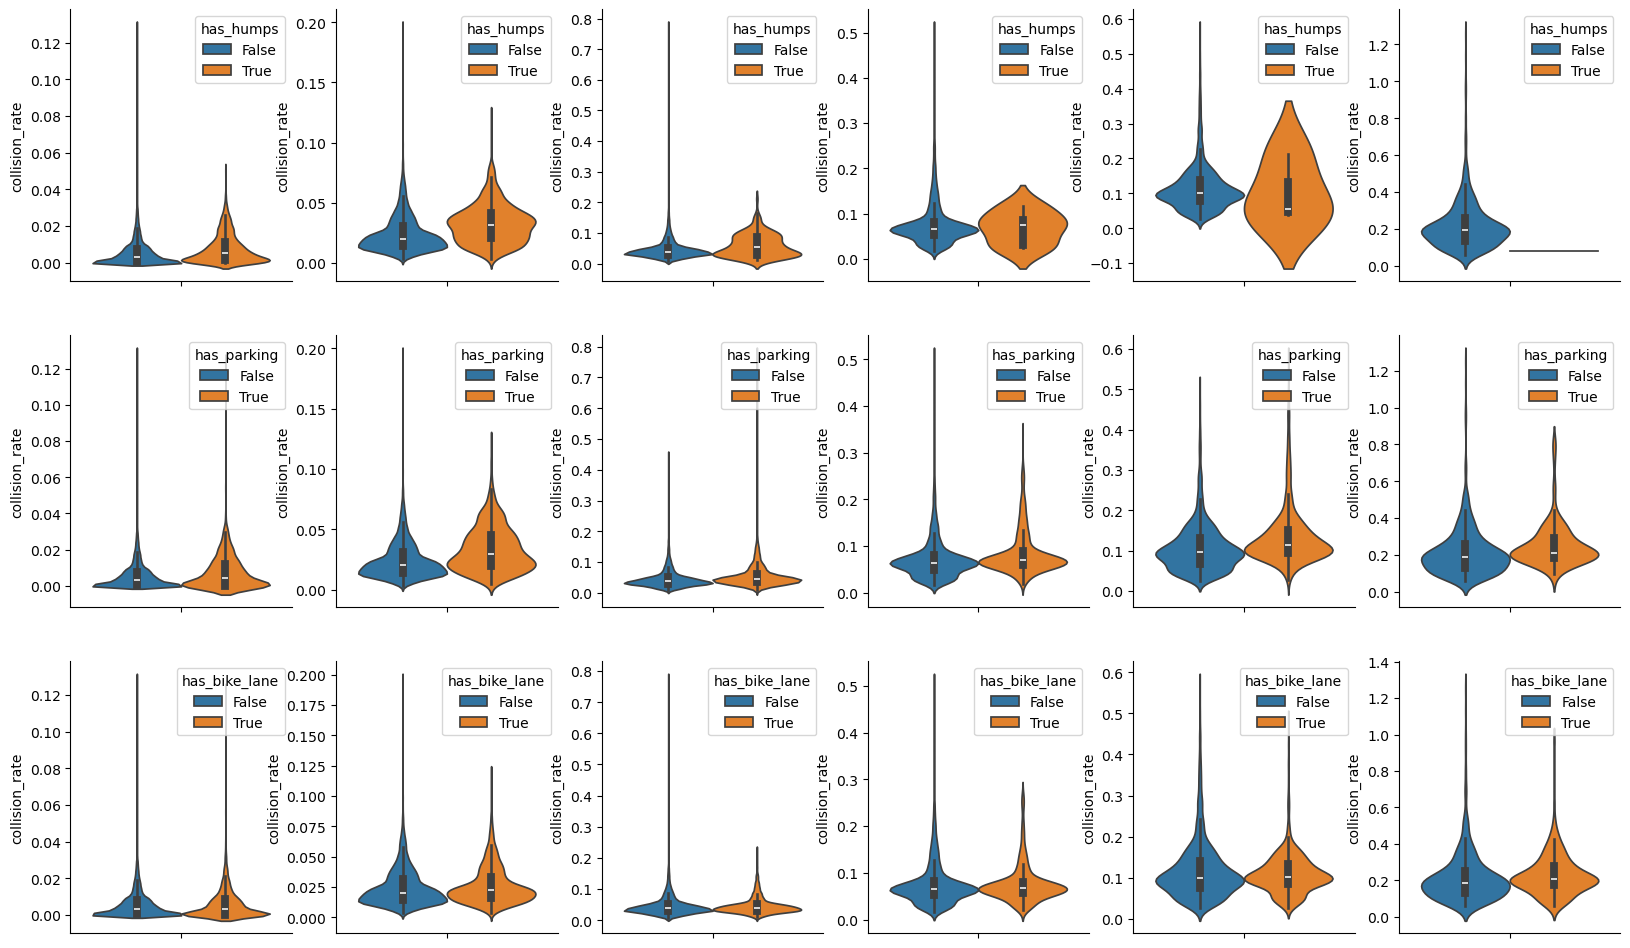

In [16]:
import seaborn as sns

_, ax = plt.subplots(3, 6, figsize=(20, 12))

boolean_feats = ["has_humps", "has_parking", "has_bike_lane"]

for i, p in enumerate(percentiles):
    for j, f in enumerate(boolean_feats):
        sns.violinplot(
            collisions_train[collisions_train["percentile"] == p],
            y="collision_rate",
            hue=f,
            ax=ax[j, i],
        )

<Axes: ylabel='log_trees'>

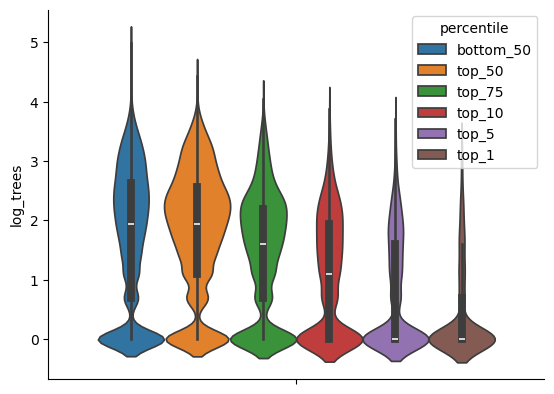

In [17]:
import numpy as np

collisions_train["log_trees"] = np.log1p(collisions_train["n_trees"])
sns.violinplot(collisions_train, y="log_trees", hue="percentile")

<Axes: ylabel='log_leng'>

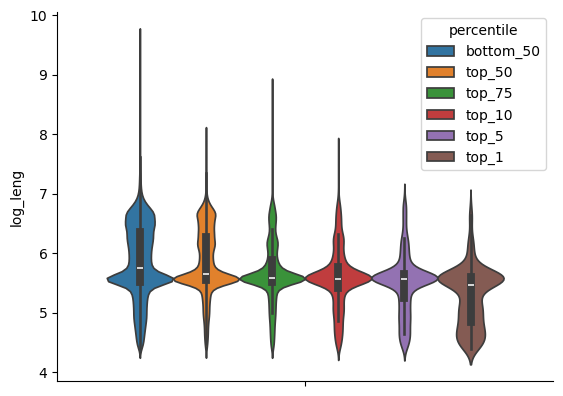

In [18]:
collisions_train["log_leng"] = np.log1p(collisions_train["shape_leng"])
sns.violinplot(collisions_train, y="log_leng", hue="percentile")

In [19]:
mean_imputer = SimpleImputer(strategy="mean", missing_values=0)
collisions_train[["st_width"]] = mean_imputer.fit_transform(
    collisions_train[["st_width"]]
)

<Axes: ylabel='log_width'>

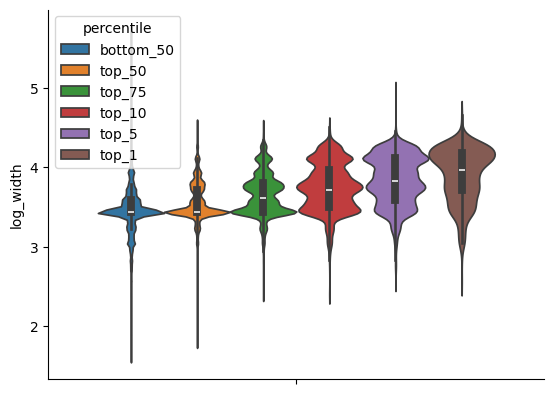

In [20]:
collisions_train["log_width"] = np.log1p(collisions_train["st_width"])
sns.violinplot(collisions_train, y="log_width", hue="percentile")

In [21]:
collisions_train["inv_trees"] = 1 / (1 + collisions_train["log_trees"])

### Logistic regression

In [22]:
collisions_train.columns

Index(['bike_lane', 'st_width', 'shape_leng', 'post_type', 'pre_type',
       'st_name', 'has_humps', 'collision_rate', 'n_trees', 'speed_limit',
       'traffic_volume', 'n_parking_meters', 'collision_rate_per_length',
       'percentile', 'has_bike_lane', 'has_volume_meas', 'has_parking',
       'is_av', 'is_st', 'is_rd', 'log_trees', 'log_leng', 'log_width',
       'inv_trees'],
      dtype='object')

In [23]:
regression_features = [
    "log_width",
    "log_leng",
    "inv_trees",
    "has_humps",
    "has_parking",
    "has_bike_lane",
]

In [24]:
X_train = collisions_train[regression_features]
y_train = collisions_train["percentile"].copy()

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [26]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

X_over, y_over = over_sampler.fit_resample(X_train, y_train)

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns = X_over.columns
X_norm = scaler.fit_transform(X_over)
X_norm = pd.DataFrame(X_norm, columns=columns)

X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.fit_transform(X_val)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

base_log_reg = LogisticRegression(
    multi_class="multinomial", max_iter=10000, penalty=None, solver="newton-cg"
)
base_log_reg.fit(X_train_norm, y_over)

LogisticRegression(max_iter=10000, multi_class='multinomial', penalty=None,
                   solver='newton-cg')

In [29]:
y_pred = base_log_reg.predict(X_val_norm)
acc_score = accuracy_score(y_val, y_pred)

/home/pjlemos/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [30]:
acc_score

0.49516235917826373

In [31]:
from sklearn.metrics import recall_score, precision_score


def calculate_class_recall(y_true, y_pred, class_: str):
    y_true_class = y_true >= class_
    y_pred_class = y_pred >= class_
    return recall_score(y_true_class, y_pred_class)


def calculate_class_precision(y_true, y_pred, class_: str):
    y_true_class = y_true >= class_
    y_pred_class = y_pred >= class_
    return precision_score(y_true_class, y_pred_class)

In [32]:
y_train.iloc[1] < "bottom_50"

False

In [33]:
base_log_reg.fit(X_norm, y_over)

LogisticRegression(max_iter=10000, multi_class='multinomial', penalty=None,
                   solver='newton-cg')

In [34]:
base_log_reg.coef_, base_log_reg.feature_names_in_, base_log_reg.classes_

(array([[-2.66841469,  0.8177095 , -0.60569988,  1.96394511, -1.97371283,
         -0.8787361 ],
        [ 2.01101875, -1.08092701,  1.79335785, -1.21171974,  0.73299803,
          0.32249531],
        [ 0.61487978, -0.12233852,  0.17866926, -0.92143949,  0.99793274,
          0.25740478],
        [ 1.38077962, -0.39117589,  0.82938036, -1.9888168 ,  1.12925529,
          0.16019736],
        [-1.1960468 ,  0.63511946, -1.40411481,  1.65870816, -1.01891286,
         -0.17717091],
        [-0.14221666,  0.14161246, -0.79159277,  0.49932276,  0.13243964,
          0.31580956]]),
 array(['log_width', 'log_leng', 'inv_trees', 'has_humps', 'has_parking',
        'has_bike_lane'], dtype=object),
 array(['bottom_50', 'top_1', 'top_10', 'top_5', 'top_50', 'top_75'],
       dtype=object))

In [35]:
X_norm.corr()

,log_width,log_leng,inv_trees,has_humps,has_parking,has_bike_lane
log_width,1.000000,-0.116412,0.348113,-0.094859,0.097906,0.239266
log_leng,-0.116412,1.000000,-0.411882,0.141155,0.094150,-0.038903
inv_trees,0.348113,-0.411882,1.000000,-0.130230,-0.067502,0.082428
has_humps,-0.094859,0.141155,-0.130230,1.000000,-0.038646,-0.037288
has_parking,0.097906,0.094150,-0.067502,-0.038646,1.000000,0.073996
has_bike_lane,0.239266,-0.038903,0.082428,-0.037288,0.073996,1.000000


In [36]:
percentiles = ["bottom_50", "top_50", "top_75", "top_10", "top_5", "top_1"]

In [37]:
from sklearn.metrics import log_loss

cs = np.linspace(0.001, 0.05, 50)

data_array = np.zeros(shape=(50, 6, len(regression_features) + 7))

for i, c in enumerate(cs):
    log_reg = LogisticRegression(
        multi_class="multinomial",
        max_iter=10000,
        penalty="l1",
        C=c,
        solver="saga",
        n_jobs=-1,
    )
    log_reg.fit(X_norm.values, y_over)
    y_pred_val = log_reg.predict(X_val_norm)
    y_pred_proba_val = log_reg.predict_proba(X_val_norm)
    y_pred_train = log_reg.predict(X_train_norm)
    y_pred_proba_train = log_reg.predict_proba(X_train_norm)
    val_loss = log_loss(y_val, y_pred_proba_val)
    train_loss = log_loss(y_train, y_pred_proba_train)
    data_array[i, :, 0] = c
    data_array[i, :, -6] = train_loss
    data_array[i, :, -5] = val_loss
    for j, class_ in enumerate(log_reg.classes_):
        train_precision = calculate_class_precision(y_train, y_pred_train, class_)
        val_precision = calculate_class_precision(y_val, y_pred_val, class_)
        train_recall = calculate_class_recall(y_train, y_pred_train, class_)
        val_recall = calculate_class_recall(y_val, y_pred_val, class_)
        data_array[i, j, -4] = train_recall
        data_array[i, j, -3] = val_recall
        data_array[i, j, -2] = train_precision
        data_array[i, j, -1] = val_precision
    data_array[i, :, 1:-6] = log_reg.coef_

InvalidParameterError: The 'multi_class' parameter of LogisticRegression must be a str among {'multinomial', 'ovr', 'auto'}. Got 'ovo' instead.

In [ ]:
classes = ["top_50", "top_75", "top_10", "top_5", "top_1"]

In [ ]:
classes_train_precision = dict()
classes_val_precision = dict()
classes_train_recall = dict()
classes_val_recall = dict()

for class_ in classes:
    ix = np.where(log_reg.classes_ == class_)[0][0]
    classes_train_precision[class_] = data_array[:, ix, -2]
    classes_val_precision[class_] = data_array[:, ix, -1]
    classes_train_recall[class_] = data_array[:, ix, -4]
    classes_val_recall[class_] = data_array[:, ix, -3]

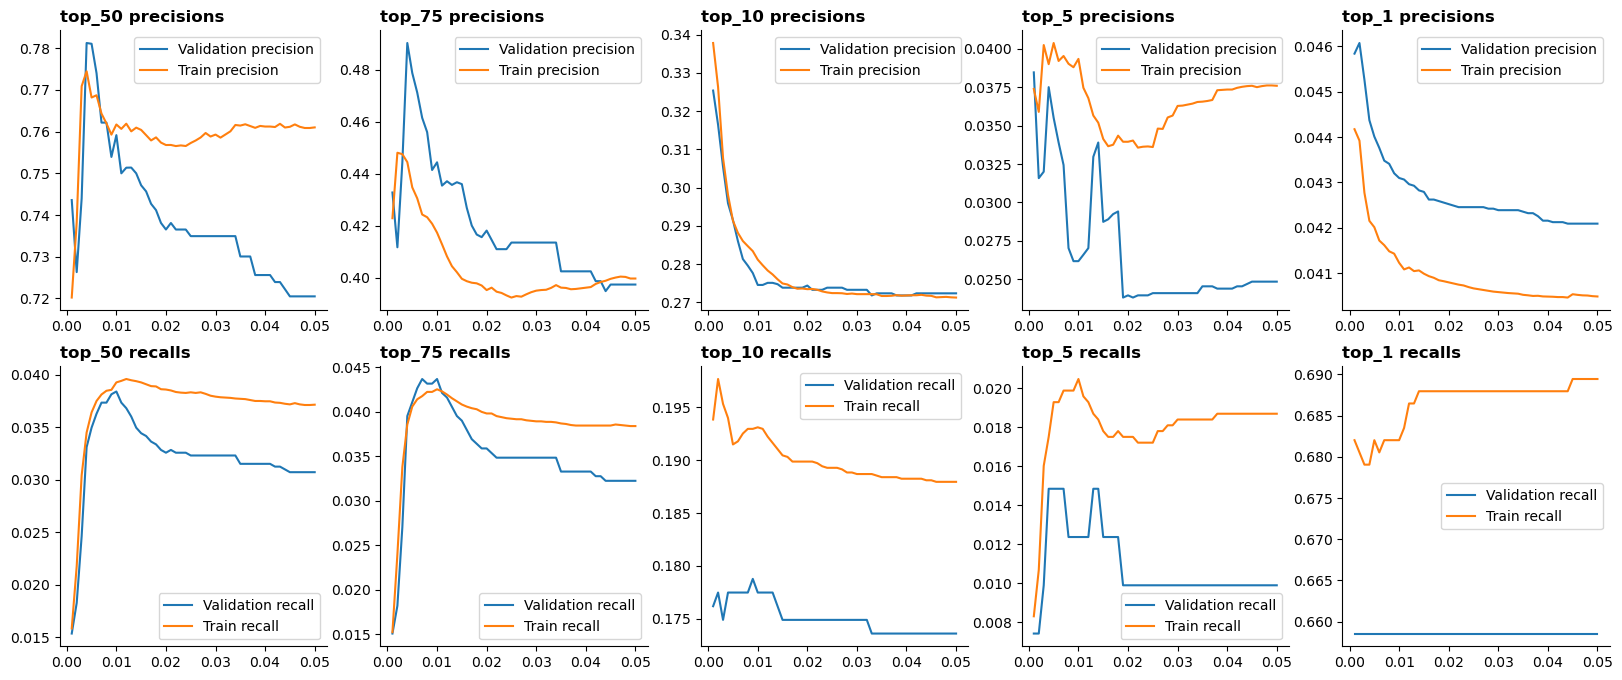

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(20, 8))

for i, class_ in enumerate(classes):
    ax[0, i].plot(cs, classes_val_precision[class_], label="Validation precision")
    ax[0, i].plot(cs, classes_train_precision[class_], label="Train precision")
    ax[0, i].set_title(f"{class_} precisions")
    ax[1, i].plot(cs, classes_val_recall[class_], label="Validation recall")
    ax[1, i].plot(cs, classes_train_recall[class_], label="Train recall")
    ax[1, i].set_title(f"{class_} recalls")
    ax[0, i].legend()
    ax[1, i].legend()

In [ ]:
log_reg_lasso = LogisticRegression(
    multi_class="multinomial",
    max_iter=10000,
    penalty="l1",
    C=0.025,
    solver="saga",
    n_jobs=-1,
)

In [ ]:
log_reg_lasso.fit(X_norm, y_over)

LogisticRegression(C=0.025, max_iter=10000, multi_class='multinomial',
                   n_jobs=-1, penalty='l1', solver='saga')

In [ ]:
log_reg_lasso.coef_, log_reg_lasso.feature_names_in_, log_reg_lasso.classes_

(array([[-2.64070583,  0.81207788, -0.5365021 ,  1.66270865, -2.16823547,
         -1.05974558],
        [ 1.88976073, -1.07074111,  1.83025392, -0.72750164,  0.44534438,
          0.07638329],
        [ 0.65129918, -0.12307501,  0.15708741, -0.980858  ,  0.75779674,
          0.01032536],
        [ 1.34040737, -0.37397038,  0.84637318, -1.20919569,  0.92821821,
         -0.01471452],
        [-1.15203437,  0.62435318, -1.33189829,  1.33705519, -1.25912666,
         -0.38544125],
        [-0.14309583,  0.13205768, -0.77561279,  0.18733906, -0.067215  ,
          0.1141764 ]]),
 array(['log_width', 'log_leng', 'inv_trees', 'has_humps', 'has_parking',
        'has_bike_lane'], dtype=object),
 array(['bottom_50', 'top_1', 'top_10', 'top_5', 'top_50', 'top_75'],
       dtype=object))

In [ ]:
lasso_scores = cross_val_score(log_reg_lasso, X_norm, y_over, cv=5, scoring="accuracy")

In [ ]:
lasso_scores.mean()

0.3403359437142181

In [ ]:
no_bike_scores = cross_val_score(
    LogisticRegression(multi_class="multinomial", max_iter=10000, solver="sag"),
    X_norm.drop(columns="has_bike_lane"),
    y_over,
    cv=5,
    scoring="accuracy",
)

In [45]:
no_bike_scores.mean()

0.33928887082627535

### Quadratic features

### Random forests

In [46]:
random_forest_features = regression_features + ["is_av", "is_st", "is_rd"]

In [47]:
X_train = collisions_train[random_forest_features].copy()

In [49]:
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

X_over, y_over = over_sampler.fit_resample(X_train, y_train)

In [50]:
X_over.columns

Index(['log_width', 'log_leng', 'inv_trees', 'has_humps', 'has_parking',
       'has_bike_lane', 'is_av', 'is_st', 'is_rd'],
      dtype='object')

In [51]:
from sklearn.ensemble import RandomForestClassifier

base_rand_forest = RandomForestClassifier()

base_rf_scores = cross_val_score(
    base_rand_forest, X_over, y_over, scoring="accuracy", cv=5
)

In [52]:
base_rf_scores.mean()

0.9102252623094722

In [64]:
base_rand_forest.fit(X_over, y_over)

RandomForestClassifier()

In [54]:
base_rand_forest.feature_importances_

array([0.16192901, 0.6488214 , 0.12037997, 0.00616595, 0.01906628,
       0.01438145, 0.01243886, 0.01104799, 0.00576909])

In [55]:
feature_imp_df = pd.DataFrame(
    base_rand_forest.feature_importances_,
    index=base_rand_forest.feature_names_in_,
    columns=["importance"],
).sort_values(by="importance", ascending=False)

In [56]:
feature_imp_df.head(20)

,importance
log_leng,0.648821
log_width,0.161929
inv_trees,0.120380
has_parking,0.019066
has_bike_lane,0.014381
is_av,0.012439
is_st,0.011048
has_humps,0.006166
is_rd,0.005769


In [95]:
example = X_over.iloc[687].copy()
example

log_width        3.496508
log_leng         5.638629
inv_trees             1.0
has_humps           False
has_parking         False
has_bike_lane       False
is_av                True
is_st               False
is_rd               False
Name: 687, dtype: object

In [96]:
base_rand_forest.predict_proba(example.values.reshape(1, -1))

/home/pjlemos/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.  , 0.  , 0.96, 0.04]])

In [57]:
base_rf_no_leng_scores = cross_val_score(
    base_rand_forest, X_over.drop(columns="log_leng"), y_over, cv=5, scoring="accuracy"
)

In [58]:
base_rf_no_leng_scores.mean()

0.46622841872706056

In [ ]:
base_rand_forest.feature_importances_

array([0.16059791, 0.67110896, 0.11696163, 0.00545719, 0.0185488 ,
       0.01251962, 0.01480589])

In [ ]:
base_rand_forest.feature_names_in_

array(['log_width', 'log_leng', 'inv_trees', 'has_humps', 'has_parking',
       'has_bike_lane', 'is_arterial'], dtype=object)

In [101]:
base_rand_forest.fit(X_over, y_over)

RandomForestClassifier()

In [102]:
from sklearn.metrics import confusion_matrix

y_pred = base_rand_forest.predict(X_over)
confusion_matrix(y_over, y_pred)

array([[37716,     0,     1,     0,     3,     4],
       [    0, 37724,     0,     0,     0,     0],
       [    0,     0, 37724,     0,     0,     0],
       [    0,     0,     0, 37724,     0,     0],
       [    0,     0,     0,     0, 37723,     1],
       [    0,     0,     0,     0,     2, 37722]])

In [103]:
30521 / 37724

0.8090605450111334